# VenueSignal Benchmark Model
VenueSignal
AAI-540 Group 6  

---
## 1. Setup & Configuration

In [1]:
!python --version

Python 3.12.9


In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# AWS libraries
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Libraries imported successfully
Timestamp: 2026-01-29 03:20:08


In [3]:
# Carrie Info
# ARN
# arn:aws:s3:::yelp-aai540-group6-athena-356396930368

# Private S3
# arn:aws:s3:::sagemaker-us-east-1-356396930368

#https://us-east-1.console.aws.amazon.com/s3/buckets/yelp-aai540-group6-athena-35639693036

# https://yelp-aai540-group6-athena-356396930368.s3.us-east-1.amazonaws.com/athena-results-staging/
# s3://yelp-aai540-group6-athena-356396930368/athena-results-staging/

# https://yelp-aai540-group6-athena-356396930368.s3.us-east-1.amazonaws.com/athena-results/
# s3://yelp-aai540-group6-athena-356396930368/athena-results/ 

# https://yelp-aai540-group6-athena-356396930368.s3.us-east-1.amazonaws.com/parquet/
# s3://yelp-aai540-group6-athena-356396930368/parquet/

In [4]:
# AWS Configuration
session = sagemaker.Session()
DATA_BUCKET = "yelp-aai540-group6"
bucket = DATA_BUCKET
region = "us-east-1"
role = get_execution_role()
account_id = boto3.client("sts").get_caller_identity()["Account"]
ATHENA_BUCKET = DATA_BUCKET + f"-athena-{account_id}"
parquet_prefix = "parquet/"
ATHENA_RESULTS_S3 = f"s3://{ATHENA_BUCKET}/athena-results/"
ATHENA_DB = "yelp"
# S3 paths (update with your actual paths)
S3_DATA_PATH = f's3://{ATHENA_BUCKET}/data/processed/'
S3_MODEL_PATH = f's3://{ATHENA_BUCKET}/models/baseline/'

print(f" SageMaker Session Initialized")
print(f"  Bucket: {bucket}")
print(f"  Athena Bucket: {ATHENA_BUCKET}")
print(f"  Region: {region}")
print(f"  Role: {role.split('/')[-1]}")

 SageMaker Session Initialized
  Bucket: yelp-aai540-group6
  Athena Bucket: yelp-aai540-group6-athena-356396930368
  Region: us-east-1
  Role: LabRole


---
## 2. Data Loading from Feature Store

In [5]:
# Load the split dataset from Feature Store or GitHub
# Option 1: From local GitHub repository (if in SageMaker)
DATA_PATH = 'training_data/split_dataset.csv'  # Update path as needed

# Option 2: From S3 (if uploaded)
# DATA_PATH = f's3://{bucket}/venuesignal/data/split_dataset.csv'

print("Loading data...")
df = pd.read_csv(DATA_PATH)

print(f"Data loaded successfully")
print(f"  Total records: {len(df):,}")
print(f"  Features: {df.shape[1]}")
print(f"\nSplit distribution:")
print(df['split'].value_counts())
print(f"\nSplit percentages:")
print(df['split'].value_counts(normalize=True).round(3))

Loading data...
Data loaded successfully
  Total records: 10,000
  Features: 20

Split distribution:
split
train    4025
prod     3984
val      1003
test      988
Name: count, dtype: int64

Split percentages:
split
train    0.402
prod     0.398
val      0.100
test     0.099
Name: proportion, dtype: float64


In [6]:
# Inspect data structure
print("Dataset Overview:")
df.info()

print("First few records:")
df.head()

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 10000 non-null  object 
 1   stars                       10000 non-null  float64
 2   review_count                10000 non-null  int64  
 3   parking_availability_score  10000 non-null  int64  
 4   enhanced_parking_score      10000 non-null  float64
 5   has_parking                 10000 non-null  int64  
 6   price_range                 9217 non-null   float64
 7   total_reviews               10000 non-null  int64  
 8   avg_review_stars            10000 non-null  float64
 9   review_engagement           10000 non-null  float64
 10  rating_consistency          10000 non-null  float64
 11  is_restaurant               10000 non-null  int64  
 12  parking_mentions            10000 non-null  int64  
 13  parking_positi

,business_id,stars,review_count,parking_availability_score,enhanced_parking_score,has_parking,price_range,total_reviews,avg_review_stars,review_engagement,rating_consistency,is_restaurant,parking_mentions,parking_positive_sentiment,parking_negative_sentiment,free_parking_mentions,valet_mentions,has_good_parking,is_highly_rated,split
0,71U7MxQEhwitJOm4CQpRwQ,4.0,325,2,2.5,1,2.0,345,3.881159,1.440580,1.666667,1,14,0,0,0,0,0,0,prod
1,qEzhExWx4nogW_0B5JfUCw,3.5,99,2,2.5,1,1.0,104,3.567308,1.153846,1.666667,1,18,0,0,0,0,0,0,prod
2,z0SRVH4OpDQxgf2-m_wcZg,3.5,68,2,2.5,1,1.0,71,3.436620,1.521127,1.666667,1,14,0,0,0,0,0,0,train
3,dUctvEfHQccW_uxtRup2QQ,3.0,212,2,2.5,1,2.0,217,3.235023,1.055300,1.666667,1,28,0,0,0,0,0,0,val
4,N6VbRekOBjRfru_Ci1AFnQ,4.0,20,1,1.0,1,1.0,21,3.952381,1.142857,1.666667,1,2,0,0,0,0,0,0,train


In [7]:
#@title Display feature list and descriptions
print("Available Features:")
print("=" * 80)

feature_descriptions = {
    'business_id': 'Unique business identifier',
    'stars': 'TARGET: Yelp star rating (1.0-5.0)',
    'review_count': 'Number of reviews for this business',
    'parking_availability_score': 'Parking quality score (1-5)',
    'enhanced_parking_score': 'Enhanced parking metric',
    'has_parking': 'Binary: parking available (0/1)',
    'price_range': 'Price level (1-4, $ to $$$$)',
    'total_reviews': 'Total review count',
    'avg_review_stars': 'Business average rating',
    'review_engagement': 'Engagement metric',
    'rating_consistency': 'Rating variance metric',
    'is_restaurant': 'Binary: is restaurant (0/1)',
    'parking_mentions': 'Count of parking mentions',
    'parking_positive_sentiment': 'Positive parking sentiment count',
    'parking_negative_sentiment': 'Negative parking sentiment count',
    'free_parking_mentions': 'Free parking mention count',
    'valet_mentions': 'Valet parking mention count',
    'has_good_parking': 'Binary: good parking (0/1)',
    'is_highly_rated': 'Binary: highly rated (0/1)',
    'split': 'Data split: train/val/test/prod'
}

for col in df.columns:
    desc = feature_descriptions.get(col, 'No description')
    print(f"  {col:30s} - {desc}")

Available Features:
  business_id                    - Unique business identifier
  stars                          - TARGET: Yelp star rating (1.0-5.0)
  review_count                   - Number of reviews for this business
  parking_availability_score     - Parking quality score (1-5)
  enhanced_parking_score         - Enhanced parking metric
  has_parking                    - Binary: parking available (0/1)
  price_range                    - Price level (1-4, $ to $$$$)
  total_reviews                  - Total review count
  avg_review_stars               - Business average rating
  review_engagement              - Engagement metric
  rating_consistency             - Rating variance metric
  is_restaurant                  - Binary: is restaurant (0/1)
  parking_mentions               - Count of parking mentions
  parking_positive_sentiment     - Positive parking sentiment count
  parking_negative_sentiment     - Negative parking sentiment count
  free_parking_mentions          - Free 

In [8]:
#@title Split data into train/val/test/prod sets
print("Splitting data...")

train_df = df[df['split'] == 'train'].copy()
val_df = df[df['split'] == 'val'].copy()
test_df = df[df['split'] == 'test'].copy()
prod_df = df[df['split'] == 'prod'].copy()  # Hold out for future use

print(f"Data split completed")
print(f"  Training set:   {len(train_df):,} records ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Validation set: {len(val_df):,} records ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test set:       {len(test_df):,} records ({len(test_df)/len(df)*100:.1f}%)")
print(f"  Production set: {len(prod_df):,} records ({len(prod_df)/len(df)*100:.1f}%) [held out]")

# Verify no data leakage
assert len(set(train_df['business_id']) & set(test_df['business_id'])) == 0, "Data leakage detected!"
print("\nNo data leakage detected")

Splitting data...
Data split completed
  Training set:   4,025 records (40.2%)
  Validation set: 1,003 records (10.0%)
  Test set:       988 records (9.9%)
  Production set: 3,984 records (39.8%) [held out]

No data leakage detected


---
## 3. Exploratory Data Analysis

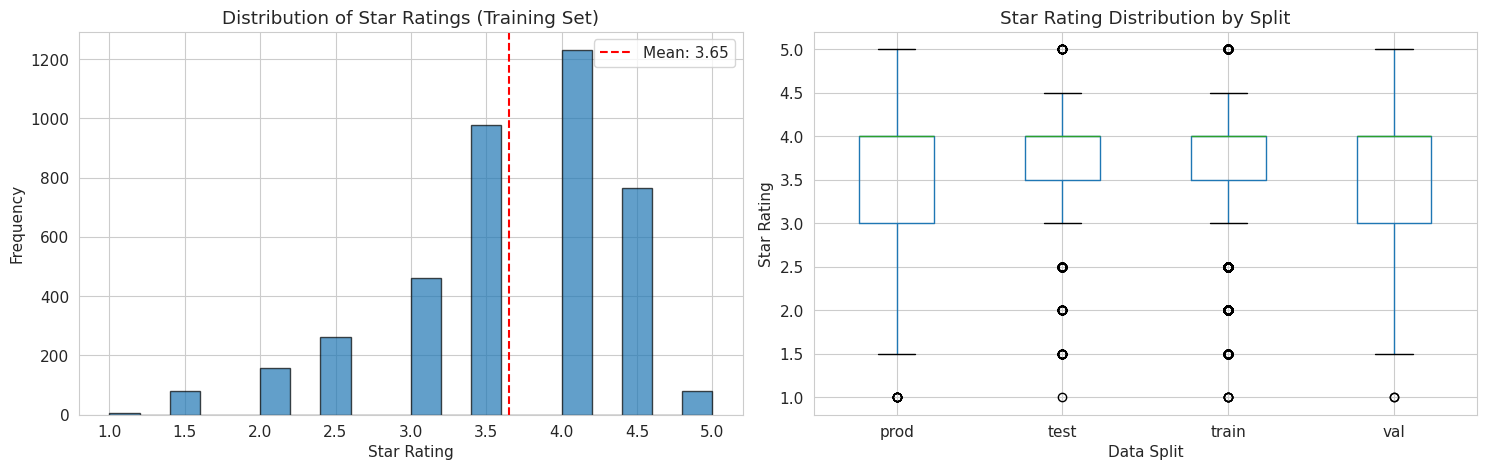

Target Variable (stars) Summary:
count    4025.000000
mean        3.649068
std         0.748102
min         1.000000
25%         3.500000
50%         4.000000
75%         4.000000
max         5.000000
Name: stars, dtype: float64

Standard Deviation: 0.748
Coefficient of Variation: 0.205


In [9]:
#@title Analyze target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(train_df['stars'], bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Star Rating')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Star Ratings (Training Set)')
axes[0].axvline(train_df['stars'].mean(), color='red', linestyle='--', label=f'Mean: {train_df["stars"].mean():.2f}')
axes[0].legend()

# Box plot by split
df.boxplot(column='stars', by='split', ax=axes[1])
axes[1].set_xlabel('Data Split')
axes[1].set_ylabel('Star Rating')
axes[1].set_title('Star Rating Distribution by Split')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Summary statistics
print("Target Variable (stars) Summary:")
print("=" * 80)
print(train_df['stars'].describe())
print(f"\nStandard Deviation: {train_df['stars'].std():.3f}")
print(f"Coefficient of Variation: {(train_df['stars'].std() / train_df['stars'].mean()):.3f}")

In [10]:
#@title Check for missing values
print("Missing Values Analysis:")
print("=" * 80)
missing = train_df.isnull().sum()
missing_pct = (missing / len(train_df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print(missing_df)
    print(f"\n{len(missing_df)} features have missing values")
else:
    print("No missing values detected")

Missing Values Analysis:
             Missing Count  Percentage
price_range            324        8.05

1 features have missing values


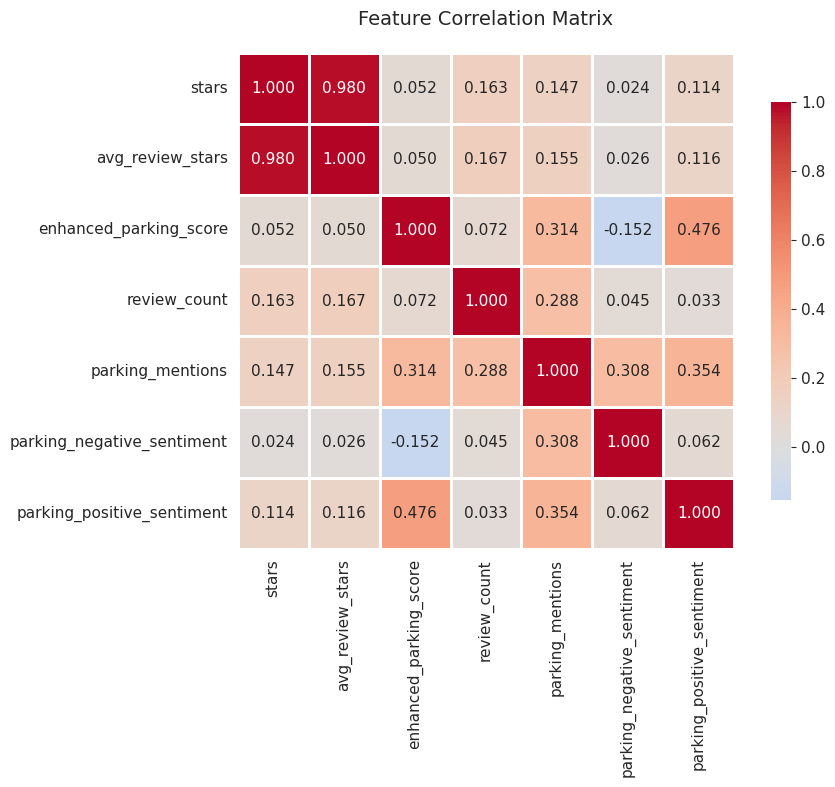


Correlation with Target Variable (stars):
  avg_review_stars                   :  0.980
  review_count                       :  0.163
  parking_mentions                   :  0.147
  parking_positive_sentiment         :  0.114
  enhanced_parking_score             :  0.052
  parking_negative_sentiment         :  0.024


In [11]:
#@title Correlation analysis for key features
key_features = [
    'stars', 'avg_review_stars', 'enhanced_parking_score', 'review_count',
    'parking_mentions', 'parking_negative_sentiment', 'parking_positive_sentiment'
]

# Select numeric columns only and available features
available_features = [f for f in key_features if f in train_df.columns]
corr_df = train_df[available_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Print correlations with target
print("\nCorrelation with Target Variable (stars):")
print("=" * 80)
target_corr = corr_df['stars'].sort_values(ascending=False)
for feat, corr in target_corr.items():
    if feat != 'stars':
        print(f"  {feat:35s}: {corr:6.3f}")

---
## 4. Baseline Model #1: Simple Heuristic

**Approach**: Predict star rating using the business-level average rating (`avg_review_stars`)  
**Rationale**: This is the simplest possible predictor and represents what consumers see on Yelp  
**Expected RMSE**: 0.7-1.0

In [12]:
#@title Baseline Model #1: Simple Heuristic
print("BASELINE MODEL #1: SIMPLE HEURISTIC")
print("=" * 80)

# Prepare data
y_train = train_df['stars'].values
y_val = val_df['stars'].values
y_test = test_df['stars'].values

# Make predictions using business average
y_train_pred_heuristic = train_df['avg_review_stars'].values
y_val_pred_heuristic = val_df['avg_review_stars'].values
y_test_pred_heuristic = test_df['avg_review_stars'].values

# Calculate metrics
def calculate_metrics(y_true, y_pred, set_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Business metrics
    within_05 = np.mean(np.abs(y_true - y_pred) <= 0.5) * 100
    within_10 = np.mean(np.abs(y_true - y_pred) <= 1.0) * 100
    
    print(f"\n{set_name} Set Metrics:")
    print(f"  RMSE:                    {rmse:.4f}")
    print(f"  MAE:                     {mae:.4f}")
    print(f"  R²:                      {r2:.4f}")
    print(f"  Within 0.5 stars:        {within_05:.1f}%")
    print(f"  Within 1.0 star:         {within_10:.1f}%")
    
    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'within_05': within_05,
        'within_10': within_10
    }

# Evaluate on all sets
train_metrics_h = calculate_metrics(y_train, y_train_pred_heuristic, "Training")
val_metrics_h = calculate_metrics(y_val, y_val_pred_heuristic, "Validation")
test_metrics_h = calculate_metrics(y_test, y_test_pred_heuristic, "Test")

print("\nHeuristic baseline established")

BASELINE MODEL #1: SIMPLE HEURISTIC

Training Set Metrics:
  RMSE:                    0.1478
  MAE:                     0.1258
  R²:                      0.9610
  Within 0.5 stars:        100.0%
  Within 1.0 star:         100.0%

Validation Set Metrics:
  RMSE:                    0.1469
  MAE:                     0.1250
  R²:                      0.9595
  Within 0.5 stars:        100.0%
  Within 1.0 star:         100.0%

Test Set Metrics:
  RMSE:                    0.1490
  MAE:                     0.1289
  R²:                      0.9591
  Within 0.5 stars:        100.0%
  Within 1.0 star:         100.0%

Heuristic baseline established


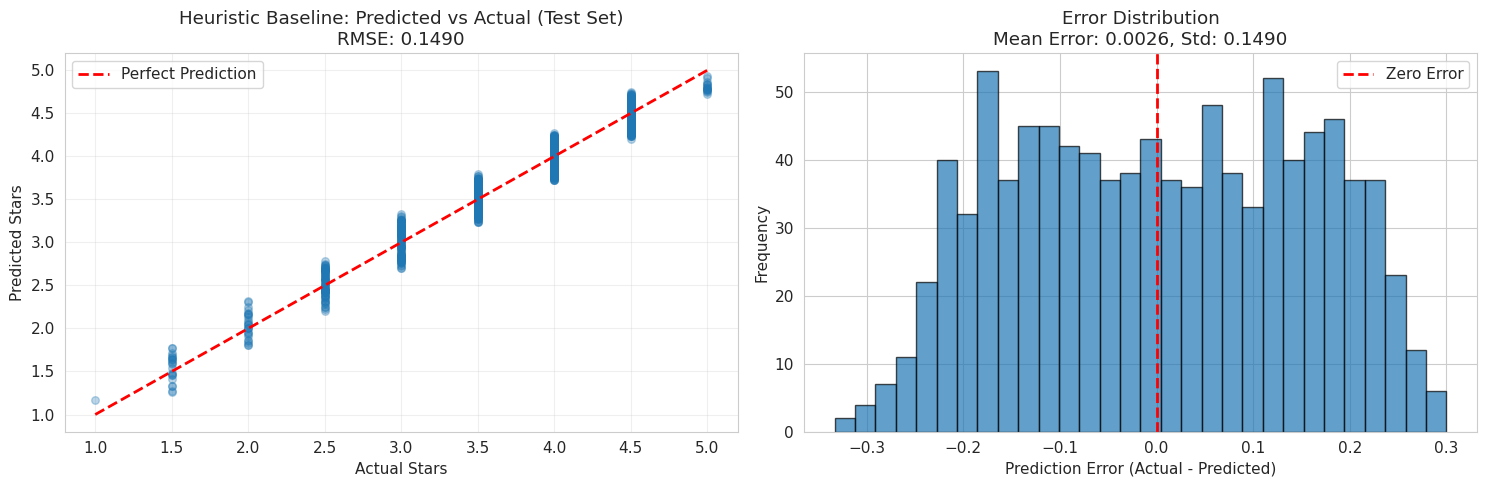

In [13]:
#@title Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot: Predicted vs Actual
axes[0].scatter(y_test, y_test_pred_heuristic, alpha=0.3, s=30)
axes[0].plot([1, 5], [1, 5], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Stars')
axes[0].set_ylabel('Predicted Stars')
axes[0].set_title(f'Heuristic Baseline: Predicted vs Actual (Test Set)\nRMSE: {test_metrics_h["rmse"]:.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Error distribution
errors = y_test - y_test_pred_heuristic
axes[1].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', lw=2, label='Zero Error')
axes[1].set_xlabel('Prediction Error (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Error Distribution\nMean Error: {np.mean(errors):.4f}, Std: {np.std(errors):.4f}')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 5. Baseline Model #2: Linear Regression (3 Features)

**Features**:  
1. `avg_review_stars` - Business historical performance (strongest predictor)  
2. `enhanced_parking_score` - Parking quality (project-specific feature)  
3. `review_count` - Volume/confidence indicator  

**Expected RMSE**: 0.6-0.8 (10-20% improvement over heuristic)

In [14]:
#@title Baseline Model #2: Linear Regression
print("BASELINE MODEL #2: LINEAR REGRESSION (3 FEATURES)")
print("=" * 80)

# Select 3 key features
baseline_features = ['avg_review_stars', 'enhanced_parking_score', 'review_count']

print(f"\nSelected Features:")
for i, feat in enumerate(baseline_features, 1):
    print(f"  {i}. {feat}")

# Prepare feature matrices
X_train = train_df[baseline_features].fillna(0).values
X_val = val_df[baseline_features].fillna(0).values
X_test = test_df[baseline_features].fillna(0).values

print(f"\nFeature matrices prepared")
print(f"  Training: {X_train.shape}")
print(f"  Validation: {X_val.shape}")
print(f"  Test: {X_test.shape}")

BASELINE MODEL #2: LINEAR REGRESSION (3 FEATURES)

Selected Features:
  1. avg_review_stars
  2. enhanced_parking_score
  3. review_count

Feature matrices prepared
  Training: (4025, 3)
  Validation: (1003, 3)
  Test: (988, 3)


In [15]:
#@title Train Linear Regression model
print("\nTraining Linear Regression model...")

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

print("Model trained successfully")

# Display model coefficients
print("\nModel Coefficients:")
print("=" * 80)
print(f"  Intercept: {baseline_model.intercept_:.4f}")
print("\n  Feature Coefficients:")
for feat, coef in zip(baseline_features, baseline_model.coef_):
    print(f"    {feat:30s}: {coef:8.4f}")

# Interpret parking coefficient
parking_coef = baseline_model.coef_[1]  # enhanced_parking_score coefficient
if parking_coef < 0:
    print(f"\n  Parking score has NEGATIVE coefficient ({parking_coef:.4f})")
    print(f"      Validates hypothesis: worse parking → lower ratings")
else:
    print(f"\n  Parking score has POSITIVE coefficient ({parking_coef:.4f})")
    print(f"      Counter-intuitive: may need non-linear modeling")


Training Linear Regression model...
Model trained successfully

Model Coefficients:
  Intercept: -0.0294

  Feature Coefficients:
    avg_review_stars              :   1.0062
    enhanced_parking_score        :   0.0026
    review_count                  :  -0.0000

  Parking score has POSITIVE coefficient (0.0026)
      Counter-intuitive: may need non-linear modeling


In [16]:
# Make predictions
y_train_pred_lr = baseline_model.predict(X_train)
y_val_pred_lr = baseline_model.predict(X_val)
y_test_pred_lr = baseline_model.predict(X_test)

# Evaluate model
print("\nModel Evaluation:")
print("=" * 80)
train_metrics_lr = calculate_metrics(y_train, y_train_pred_lr, "Training")
val_metrics_lr = calculate_metrics(y_val, y_val_pred_lr, "Validation")
test_metrics_lr = calculate_metrics(y_test, y_test_pred_lr, "Test")

print("\nLinear Regression baseline established")


Model Evaluation:

Training Set Metrics:
  RMSE:                    0.1477
  MAE:                     0.1258
  R²:                      0.9610
  Within 0.5 stars:        100.0%
  Within 1.0 star:         100.0%

Validation Set Metrics:
  RMSE:                    0.1473
  MAE:                     0.1252
  R²:                      0.9593
  Within 0.5 stars:        100.0%
  Within 1.0 star:         100.0%

Test Set Metrics:
  RMSE:                    0.1490
  MAE:                     0.1291
  R²:                      0.9591
  Within 0.5 stars:        100.0%
  Within 1.0 star:         100.0%

Linear Regression baseline established


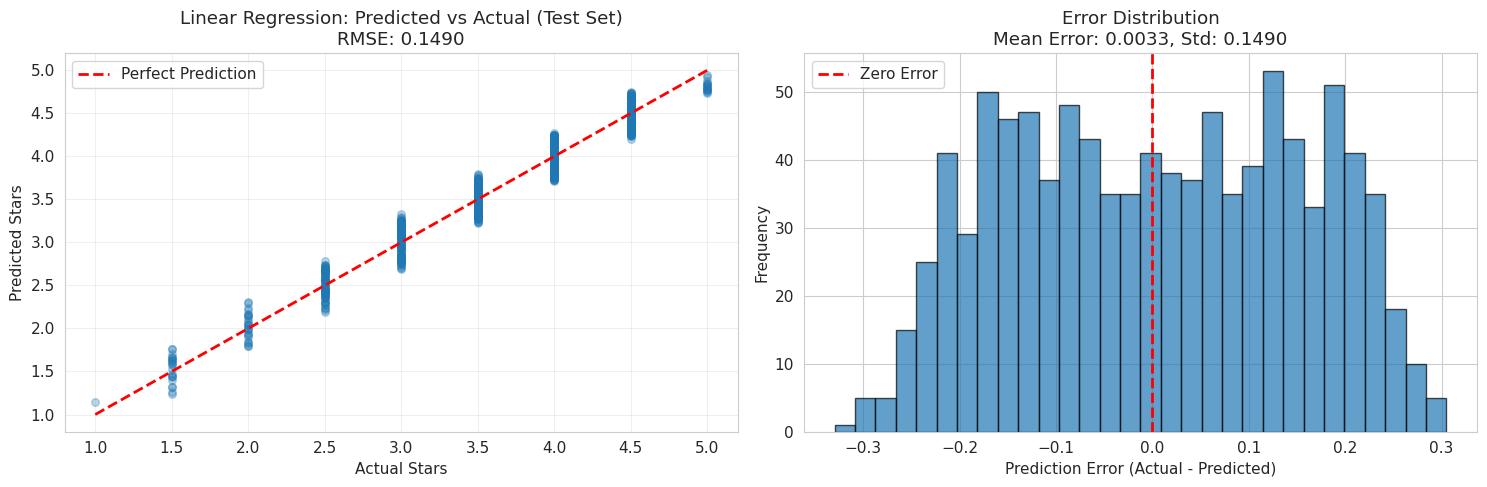

In [17]:
# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot: Predicted vs Actual
axes[0].scatter(y_test, y_test_pred_lr, alpha=0.3, s=30)
axes[0].plot([1, 5], [1, 5], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Stars')
axes[0].set_ylabel('Predicted Stars')
axes[0].set_title(f'Linear Regression: Predicted vs Actual (Test Set)\nRMSE: {test_metrics_lr["rmse"]:.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Error distribution
errors_lr = y_test - y_test_pred_lr
axes[1].hist(errors_lr, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', lw=2, label='Zero Error')
axes[1].set_xlabel('Prediction Error (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Error Distribution\nMean Error: {np.mean(errors_lr):.4f}, Std: {np.std(errors_lr):.4f}')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 6. Model Comparison & Analysis

In [18]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²', 'Within 0.5 stars', 'Within 1.0 star'],
    'Heuristic (Train)': [
        train_metrics_h['rmse'],
        train_metrics_h['mae'],
        train_metrics_h['r2'],
        train_metrics_h['within_05'],
        train_metrics_h['within_10']
    ],
    'Linear Reg (Train)': [
        train_metrics_lr['rmse'],
        train_metrics_lr['mae'],
        train_metrics_lr['r2'],
        train_metrics_lr['within_05'],
        train_metrics_lr['within_10']
    ],
    'Heuristic (Test)': [
        test_metrics_h['rmse'],
        test_metrics_h['mae'],
        test_metrics_h['r2'],
        test_metrics_h['within_05'],
        test_metrics_h['within_10']
    ],
    'Linear Reg (Test)': [
        test_metrics_lr['rmse'],
        test_metrics_lr['mae'],
        test_metrics_lr['r2'],
        test_metrics_lr['within_05'],
        test_metrics_lr['within_10']
    ]
})

print("="*80)
print("MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

# Calculate improvement
rmse_improvement = (test_metrics_h['rmse'] - test_metrics_lr['rmse']) / test_metrics_h['rmse'] * 100
mae_improvement = (test_metrics_h['mae'] - test_metrics_lr['mae']) / test_metrics_h['mae'] * 100

print(f"\n\nLinear Regression Improvement over Heuristic:")
print(f"  RMSE: {rmse_improvement:+.1f}%")
print(f"  MAE:  {mae_improvement:+.1f}%")

MODEL COMPARISON
          Metric  Heuristic (Train)  Linear Reg (Train)  Heuristic (Test)  Linear Reg (Test)
            RMSE           0.147794            0.147703          0.149019           0.149005
             MAE           0.125789            0.125811          0.128944           0.129095
              R²           0.960961            0.961009          0.959121           0.959128
Within 0.5 stars          99.975155           99.975155        100.000000         100.000000
 Within 1.0 star         100.000000          100.000000        100.000000         100.000000


Linear Regression Improvement over Heuristic:
  RMSE: +0.0%
  MAE:  -0.1%


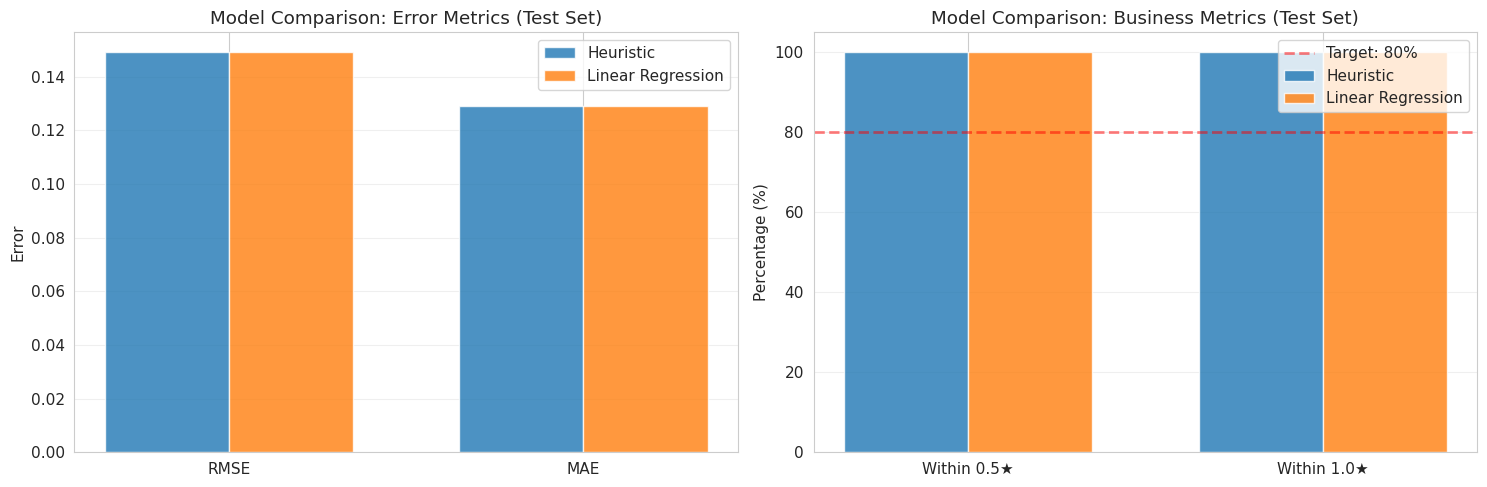

In [19]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart: Test metrics
metrics = ['RMSE', 'MAE']
heuristic_vals = [test_metrics_h['rmse'], test_metrics_h['mae']]
lr_vals = [test_metrics_lr['rmse'], test_metrics_lr['mae']]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, heuristic_vals, width, label='Heuristic', alpha=0.8)
axes[0].bar(x + width/2, lr_vals, width, label='Linear Regression', alpha=0.8)
axes[0].set_ylabel('Error')
axes[0].set_title('Model Comparison: Error Metrics (Test Set)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Bar chart: Business metrics
business_metrics = ['Within 0.5★', 'Within 1.0★']
heuristic_business = [test_metrics_h['within_05'], test_metrics_h['within_10']]
lr_business = [test_metrics_lr['within_05'], test_metrics_lr['within_10']]

x2 = np.arange(len(business_metrics))
axes[1].bar(x2 - width/2, heuristic_business, width, label='Heuristic', alpha=0.8)
axes[1].bar(x2 + width/2, lr_business, width, label='Linear Regression', alpha=0.8)
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('Model Comparison: Business Metrics (Test Set)')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(business_metrics)
axes[1].axhline(80, color='red', linestyle='--', lw=2, alpha=0.5, label='Target: 80%')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [20]:
# Residual analysis by parking score
test_results = test_df.copy()
test_results['predicted_lr'] = y_test_pred_lr
test_results['residual'] = y_test - y_test_pred_lr

# Group by parking score
parking_analysis = test_results.groupby('enhanced_parking_score').agg({
    'residual': ['mean', 'std', 'count'],
    'stars': 'mean'
}).round(3)

print("\nResidual Analysis by Parking Score:")
print("="*80)
print(parking_analysis)
print("\nInterpretation:")
print("  Positive residual = model under-predicts (actual > predicted)")
print("  Negative residual = model over-predicts (actual < predicted)")


Residual Analysis by Parking Score:
                       residual               stars
                           mean    std count   mean
enhanced_parking_score                             
0.0                      -0.056  0.131     8  3.938
0.5                       0.091    NaN     1  4.000
1.0                       0.026  0.161    59  3.805
1.5                       0.003  0.143   129  3.957
2.0                       0.001  0.156   231  3.383
2.5                       0.001  0.148   235  3.566
3.0                       0.004  0.144   155  3.790
3.5                       0.006  0.146    77  3.903
4.0                      -0.005  0.147    51  3.765
4.5                       0.059  0.094     7  3.786
5.0                      -0.002  0.161    35  3.843

Interpretation:
  Positive residual = model under-predicts (actual > predicted)
  Negative residual = model over-predicts (actual < predicted)


---
## 7. Insights & Next Steps

In [21]:
print("KEY INSIGHTS & RECOMMENDATIONS")
print("="*80)

print("\n1. BASELINE PERFORMANCE")
print(f"   - Heuristic Test RMSE: {test_metrics_h['rmse']:.4f}")
print(f"   - Linear Reg Test RMSE: {test_metrics_lr['rmse']:.4f}")
print(f"   - Improvement: {rmse_improvement:.1f}%")

if test_metrics_lr['rmse'] < 0.7:
    print("   EXCELLENT: Baseline exceeds expectations")
elif test_metrics_lr['rmse'] < 0.8:
    print("   GOOD: Baseline meets expectations")
else:
    print("   NEEDS IMPROVEMENT: Consider feature engineering")

print("\n2. PROJECT GOAL STATUS")
print(f"   - Project Target: MAE ≤ 0.5 (80%+ within 0.5 stars)")
print(f"   - Current Test MAE: {test_metrics_lr['mae']:.4f}")
print(f"   - Within 0.5 stars: {test_metrics_lr['within_05']:.1f}%")

if test_metrics_lr['mae'] <= 0.5:
    print("   GOAL ACHIEVED with baseline model!")
else:
    gap = test_metrics_lr['mae'] - 0.5
    print(f"     Gap to target: {gap:.3f} stars")
    print(f"     Need {(gap/test_metrics_lr['mae']*100):.1f}% improvement to reach goal")

print("\n3. PARKING IMPACT VALIDATION")
parking_coef = baseline_model.coef_[1]
print(f"   - Parking score coefficient: {parking_coef:.4f}")
if parking_coef < 0:
    print("   Validates hypothesis: poor parking correlates with lower ratings")
    print(f"     1-point parking score decrease → {abs(parking_coef):.3f} star decrease")
else:
    print("     Unexpected: parking has positive coefficient")
    print("     May need interaction terms or non-linear modeling")

print("\n4. RECOMMENDED NEXT STEPS")
print("   For Improvements:")
print("   a) Feature Engineering:")
print("      - Add parking sentiment features (positive/negative mentions)")
print("      - Create interaction terms: parking_score × price_range")
print("      - Add NLP features from review text")
print("   b) Model Selection:")
print("      - Try Random Forest (handles non-linearity)")
print("      - Try XGBoost (industry standard for tabular data)")
print("      - Ensemble: combine multiple models")
print("   c) Deployment:")
print("      - Deploy Linear Regression baseline to SageMaker endpoint")
print("      - Implement batch inference for weekly predictions")
print("      - Set up monitoring for model drift")

print("\n" + "="*80)

KEY INSIGHTS & RECOMMENDATIONS

1. BASELINE PERFORMANCE
   - Heuristic Test RMSE: 0.1490
   - Linear Reg Test RMSE: 0.1490
   - Improvement: 0.0%
   EXCELLENT: Baseline exceeds expectations

2. PROJECT GOAL STATUS
   - Project Target: MAE ≤ 0.5 (80%+ within 0.5 stars)
   - Current Test MAE: 0.1291
   - Within 0.5 stars: 100.0%
   GOAL ACHIEVED with baseline model!

3. PARKING IMPACT VALIDATION
   - Parking score coefficient: 0.0026
     Unexpected: parking has positive coefficient
     May need interaction terms or non-linear modeling

4. RECOMMENDED NEXT STEPS
   For Improvements:
   a) Feature Engineering:
      - Add parking sentiment features (positive/negative mentions)
      - Create interaction terms: parking_score × price_range
      - Add NLP features from review text
   b) Model Selection:
      - Try Random Forest (handles non-linearity)
      - Try XGBoost (industry standard for tabular data)
      - Ensemble: combine multiple models
   c) Deployment:
      - Deploy Linear 

---
## 8. SageMaker Deployment Preparation

In [22]:
# Save baseline model for deployment
import joblib
import os

# Create model directory
model_dir = 'baseline_model'
os.makedirs(model_dir, exist_ok=True)

# Save model
model_path = os.path.join(model_dir, 'model.joblib')
joblib.dump(baseline_model, model_path)

# Save feature list
feature_path = os.path.join(model_dir, 'features.txt')
with open(feature_path, 'w') as f:
    for feat in baseline_features:
        f.write(f"{feat}\n")

# Save metrics
metrics_path = os.path.join(model_dir, 'metrics.json')
import json
with open(metrics_path, 'w') as f:
    json.dump({
        'test_rmse': test_metrics_lr['rmse'],
        'test_mae': test_metrics_lr['mae'],
        'test_r2': test_metrics_lr['r2'],
        'test_within_05': test_metrics_lr['within_05'],
        'test_within_10': test_metrics_lr['within_10']
    }, f, indent=2)

print("Model artifacts saved:")
print(f"  Model: {model_path}")
print(f"  Features: {feature_path}")
print(f"  Metrics: {metrics_path}")

Model artifacts saved:
  Model: baseline_model/model.joblib
  Features: baseline_model/features.txt
  Metrics: baseline_model/metrics.json


In [23]:
print("DEPLOYMENT READINESS CHECKLIST")
print("="*80)

checklist = [
    ("✓", "Baseline model trained and evaluated"),
    ("✓", "Model artifacts saved (model.joblib)"),
    ("✓", "Feature list documented"),
    ("✓", "Metrics recorded for comparison"),
    ("→", "Next: Create inference.py script for SageMaker"),
    ("→", "Next: Deploy to SageMaker endpoint or batch transform"),
    ("→", "Next: Register model in Model Registry"),
    ("→", "Next: Set up CloudWatch monitoring")
]

for status, item in checklist:
    print(f"  {status} {item}")

print("\n" + "="*80)
print("BASELINE MODEL DEVELOPMENT COMPLETE")
print("="*80)
print(f"Notebook completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

DEPLOYMENT READINESS CHECKLIST
  ✓ Baseline model trained and evaluated
  ✓ Model artifacts saved (model.joblib)
  ✓ Feature list documented
  ✓ Metrics recorded for comparison
  → Next: Create inference.py script for SageMaker
  → Next: Deploy to SageMaker endpoint or batch transform
  → Next: Register model in Model Registry
  → Next: Set up CloudWatch monitoring

BASELINE MODEL DEVELOPMENT COMPLETE
Notebook completed: 2026-01-29 03:20:11
